In [1]:
import csv
import pandas as pd
import operator
import xgboost
from xgboost import XGBRegressor # you have to install it first!
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew 
color = sns.color_palette()
sns.set_style('darkgrid')

In [3]:
sample = pd.read_csv(r'all\sample_submission.csv', sep = ',')
sample.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


# Test file

In [4]:
test = pd.read_csv(r'all\test.csv', sep = ',')
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# set of columns with at least one NaN value
nan_dict = {}
for col in test:
    nan_count = test[test[col].isna()]
    if len(nan_count) > 0:
        nan_dict[col] = len(nan_count)
        
sorted_nan = sorted(nan_dict.items(), key = operator.itemgetter(1))
sorted_nan.reverse()

In [6]:
# creating a set of columns names (with NaN values in test)
test_li = set()
for i in range(len(sorted_nan)):
    test_li.add(sorted_nan[i][0])

**Alley** has 107 null values and the remaining are NaN.  ---> drop ?

**MiscFeature** has 3 second garage, 2 other, 46 shed and the remaining 1408 are missing. We can drop it since we don't need these informations. 

**MiscVal** has 51 different values and the remaining 1408 are missing (*except* miscval = 17000, miscfeature = nan).

**PoolArea** has 1453 zeroes and the remaining 6 are different values. 

**PoolQC** has 2 excellent and 1 good values, the remaining 3 are NaN. The information is not reliable.  ---> drop

# Train

In [7]:
train = pd.read_csv(r'all\train.csv', sep = ',')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# set of columns with at least one NaN value
nan_dict_train = {}
for col in train:
    nan_count_train = train[train[col].isna()]
    if len(nan_count_train)>0:
        nan_dict_train[col] = len(nan_count_train)
        
sorted_nan_train = sorted(nan_dict_train.items(), key = operator.itemgetter(1))
sorted_nan_train.reverse()

In [9]:
# creating a set of columns names (with NaN values in train)
train_li = set()
for i in range(len(sorted_nan_train)):
    train_li.add(sorted_nan[i][0])

## Handling with missing values

### An Extension To Imputation

In [10]:
dropped_test = test.drop('Id', axis = 1)

In [11]:
correlation = dropped_test.corr(method='pearson')
correlation.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.450505,-0.359537,0.034690,-0.071768,0.040848,0.046319,-0.012186,-0.058775,-0.079093,...,-0.108000,-0.022539,-0.025421,-0.029051,-0.029709,-0.071978,-0.017790,-0.045835,0.011366,-0.008392
LotFrontage,-0.450505,1.000000,0.644608,0.182870,-0.092312,0.122356,0.092603,0.251533,0.204621,0.046824,...,0.375581,0.157426,0.179795,0.013340,-0.037487,0.113444,0.134232,0.068161,0.008810,-0.025263
LotArea,-0.359537,0.644608,1.000000,0.107989,-0.103402,0.048314,0.036907,0.188691,0.185470,0.054199,...,0.315841,0.158483,0.164815,0.099850,-0.001846,0.088712,0.140494,0.139071,0.005152,-0.051144
OverallQual,0.034690,0.182870,0.107989,1.000000,-0.095874,0.621910,0.591267,0.453991,0.322583,-0.028199,...,0.568161,0.270790,0.288367,-0.161339,0.002803,0.022334,-0.012330,0.033784,-0.008764,-0.012291
OverallCond,-0.071768,-0.092312,-0.103402,-0.095874,1.000000,-0.361027,0.021668,-0.144261,-0.054720,0.043109,...,-0.156769,0.043058,-0.103783,0.072178,0.071285,0.033146,-0.037191,0.007236,-0.009767,0.015649


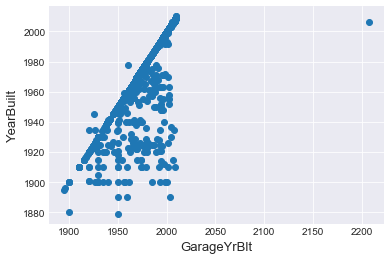

In [12]:
# there was an outlier in GarageYrBlt
fig, ax = plt.subplots()
ax.scatter(x = test['GarageYrBlt'], y = test['YearBuilt'])
plt.ylabel('YearBuilt', fontsize = 13)
plt.xlabel('GarageYrBlt', fontsize = 13)
plt.show()

In [13]:
outlier = test[test['GarageYrBlt'] > 2018]
test.loc[test.GarageYrBlt > 2018, 'GarageYrBlt'] = test['YearBuilt']

In [14]:
drop_test_col = [tup[0] for tup in sorted_nan[:6]]
imp_test_col = [tup[0] for tup in sorted_nan[6:]]

In [15]:
# dropping the columns with a higher number of missing values
to_drop = ['Id', 'Utilities', 'Condition2']
dropped_test = test.drop(drop_test_col, axis = 1)
dropped_test = dropped_test.drop(to_drop, axis = 1)
dropped_train = train.drop(drop_test_col, axis = 1)
dropped_train = dropped_train.drop(to_drop, axis = 1)

In [16]:
# distinguishing categorical and numeric features
str_feature = [i for i in dropped_test.columns 
            if isinstance(dropped_test[i][0], str)]
num_feature = [i for i 
               in (set(dropped_test.columns).difference(str_feature))]

In [17]:
# make copy to avoid changing original data (when Imputing)

new_test = dropped_test.copy()
new_train = dropped_train.copy()
reduced_train = new_train.drop('SalePrice', axis = 1)
final_train_y = np.log1p(train["SalePrice"].astype('float'))

# creating the preprocessing pipelines for numeric data
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median'))])
    #('scaler', StandardScaler())])

# creating the preprocessing pipelines for categorical data
str_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers = [('num', num_transformer, num_feature),
                    ('cat', str_transformer, str_feature)])

In [18]:
coefs = []
lambdas = (0.00001, 0.0001, 0.001, 0.01)
for lambda_ in lambdas:

    clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier',Lasso(alpha=lambda_, max_iter=50000))])
    train_fit = clf.fit(reduced_train, final_train_y)
    predictions = clf.predict(new_test)
    coefs.append(train_fit.steps[1][1].coef_)
    print(mean_squared_error(predictions, final_train_y[1:]))

C:\Users\giorg\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.31491268309459114


C:\Users\giorg\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.3116704450739859
0.30007174570752765
0.28982056508303305


(-0.05, 0.406316296424441)

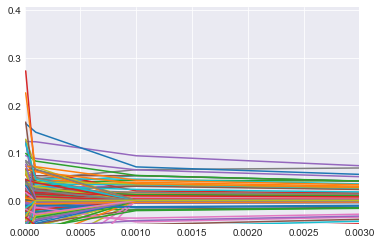

In [22]:
plt.plot(lambdas, coefs)
plt.xlim(0,0.003)
plt.ylim(-0.050,) # good lambda seems 0.00075

# Modelling

In [31]:
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier',Lasso(alpha=0.00075, max_iter=50000))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions = clf.predict(new_test)

In [32]:
pred_sale_price = pd.DataFrame(np.expm1(predictions), 
                               columns = ['SalePrice'], index = None)
pred_sale_price['Id'] = test['Id']

In [33]:
pred_sale_price

,SalePrice,Id
0,118765.193767,1461
1,138429.981576,1462
2,171844.638118,1463
3,197589.577033,1464
4,198906.784039,1465
5,169476.450536,1466
6,189494.602497,1467
7,161561.338283,1468
8,193847.548468,1469
9,120260.912283,1470


In [34]:
pred_sale_price.to_csv('predictions.csv', index = False)